In [33]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from loading_utils import parse_vqa_qtypes

In [22]:
def load_vqa_superclasses():
    mapping = parse_vqa_qtypes()
    classes = list(set(mapping.values()))
    name_mapping = {}
    for c in classes:
        name_mapping[c.replace(" ","")] = c
    return name_mapping

def load_subtask(task_dir, file, top_k):
    with open(f"{task_dir}/{file}", "rb") as f:
        layer_dict = pickle.load(f)
        top_neurons = []
        for layer, tensors in layer_dict.items():
            top, effects = tensors
            top_new = [f"{layer}_{neuron}" for neuron in top]
            neuron_with_effect = [(neuron, effect) for neuron, effect in zip(top_new, effects)]
            top_neurons.extend(neuron_with_effect)
        top_neurons.sort(key=lambda x: x[1], reverse=True)
        top_neurons = top_neurons[:top_k]
        return top_neurons

In [5]:
tasks = ["blimp", "winoground", "vqa"]
task_format = {"blimp": "BLiMP", "winoground": "Winoground", "vqa": "VQA"}

## HEATMAPS

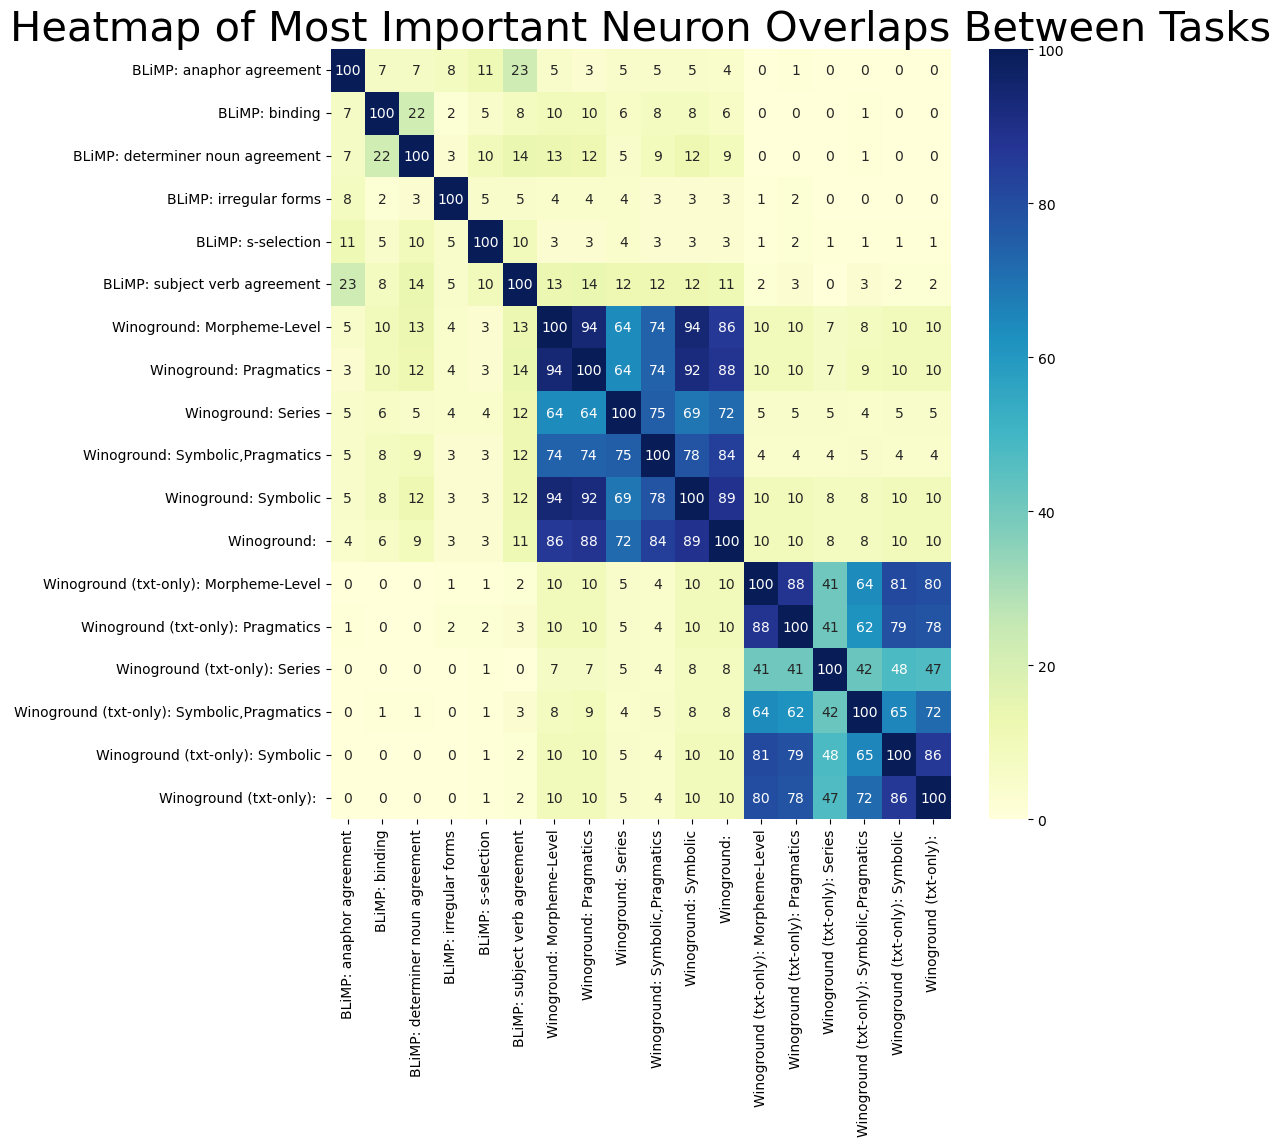

In [24]:
top_neurons_task_novqa = {}
for task in tasks:
    if task == "vqa":
        continue
    # without img
    task_dir = f"data/top_neurons/{task}/{task}_git_1vd125_s1_e29_nall_noimg/"
    for file in os.listdir(task_dir):
        if file.endswith(".pkl"):
            subtask_name = " ".join(file.split('_')[:-2])
            subtask = f"{task_format[task]}: {subtask_name}"
            top_neurons_task_novqa[subtask] = load_subtask(task_dir, file, 100)
    
    # with img
    if task != "blimp":
        task_dir = f"data/top_neurons/{task}/{task}_git_1vd125_s1_e29_nall/"
        for file in os.listdir(task_dir):
            if file.endswith(".pkl"):
                subtask_name = " ".join(file.split('_')[:-2])
                subtask_noimg = f"{task_format[task]} (txt-only): {subtask_name}"
                top_neurons_task_novqa[subtask_noimg] = load_subtask(task_dir, file, 100)


overlap_novqa = pd.DataFrame(index=top_neurons_task_novqa.keys(), columns=top_neurons_task_novqa.keys())
for task_a, neurons_a in top_neurons_task_novqa.items():
    for task_b, neurons_b in top_neurons_task_novqa.items():
        set_a = set([x[0] for x in neurons_a])
        set_b = set([x[0] for x in neurons_b])
        intersection = set_a.intersection(set_b)
        overlap_amount = len(intersection)
        overlap_novqa.loc[task_a, task_b] = overlap_amount

overlap_novqa = overlap_novqa.astype(int)


plt.figure(figsize=(10, 10))
sns.heatmap(overlap_novqa, annot=True, cmap="YlGnBu", fmt="d", annot_kws={"size": 10})
plt.title('Heatmap of Most Important Neuron Overlaps Between Tasks', fontsize=30)
plt.xticks(fontsize=10)  # Adjust x-axis font size here
plt.yticks(fontsize=10)
plt.show()

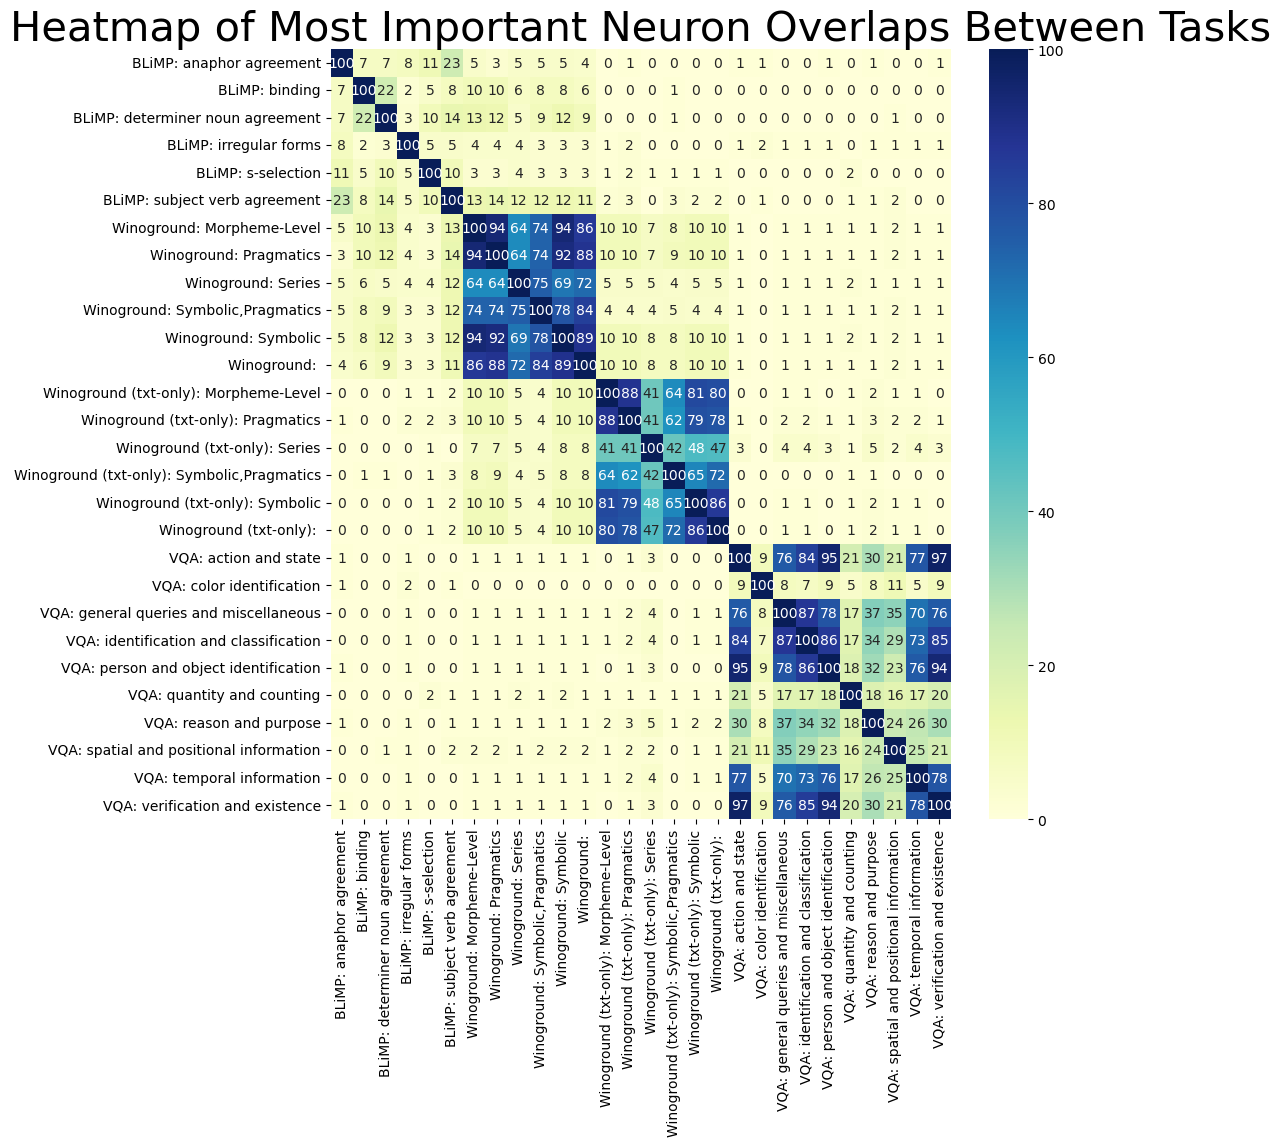

In [25]:
top_neurons_task_new_vqa = {}
vqa_names = load_vqa_superclasses()
for task in ["blimp", "winoground", "vqa"]:
    # without img
    task_dir = f"data/top_neurons/{task}/{task}_git_1vd125_s1_e29_nall_noimg/"
    for file in os.listdir(task_dir):
        if file.endswith(".pkl"):
            subtask_name = " ".join(file.split('_')[:-2])
            if task == "vqa":
                subtask_name = vqa_names[subtask_name]
            subtask = f"{task_format[task]}: {subtask_name}"
            top_neurons_task_new_vqa[subtask] = load_subtask(task_dir, file, 100)
    
    # with img
    if task != "blimp":
        task_dir = f"data/top_neurons/{task}/{task}_git_1vd125_s1_e29_nall/"
        if not os.path.isdir(task_dir):
            continue
        for file in os.listdir(task_dir):
            if file.endswith(".pkl"):
                subtask_name = " ".join(file.split('_')[:-2])
                if task == "vqa":
                    subtask_name = vqa_names[subtask_name]
                subtask_noimg = f"{task_format[task]} (txt-only): {subtask_name}"
                top_neurons_task_new_vqa[subtask_noimg] = load_subtask(task_dir, file, 100)


overlap_newqa = pd.DataFrame(index=top_neurons_task_new_vqa.keys(), columns=top_neurons_task_new_vqa.keys())
for task_a, neurons_a in top_neurons_task_new_vqa.items():
    for task_b, neurons_b in top_neurons_task_new_vqa.items():
        set_a = set([x[0] for x in neurons_a])
        set_b = set([x[0] for x in neurons_b])
        intersection = set_a.intersection(set_b)
        overlap_amount = len(intersection)
        overlap_newqa.loc[task_a, task_b] = overlap_amount

overlap_newqa = overlap_newqa.astype(int)


plt.figure(figsize=(10, 10))
sns.heatmap(overlap_newqa, annot=True, cmap="YlGnBu", fmt="d", annot_kws={"size": 10})
plt.title('Heatmap of Most Important Neuron Overlaps Between Tasks', fontsize=30)
plt.xticks(fontsize=10)  # Adjust x-axis font size here
plt.yticks(fontsize=10)
plt.show()

## Shared Neurons per Task
Only Winoground has shared neurons across all subtasks

In [28]:
def find_shared_neurons(subtask_prefix_list):

    neuron_sets = []
    for subtask, neurons in top_neurons_task_new_vqa.items():
        for prefix in subtask_prefix_list:
            if subtask.startswith(prefix):
                subtask_neurons = set([name for name, effect in neurons])
                neuron_sets.append(subtask_neurons)
    
    # Find the intersection (shared neurons) across all subtasks
    if neuron_sets:
        shared_neurons = set.intersection(*neuron_sets)
    else:
        shared_neurons = set()
    
    return shared_neurons

blimp_neurons = find_shared_neurons(["BLiMP"])
winoground_neurons = find_shared_neurons(["Winoground"])
vqa_neurons = find_shared_neurons(["VQA"])

len(blimp_neurons), len(winoground_neurons), len(vqa_neurons)

(0, 3, 0)

## MLP Layer Importance per Task

In [29]:
len(top_neurons_task_new_vqa['BLiMP: anaphor agreement'])

100

In [30]:
layers_per_subtask = {}
for subtask, top_neurons in top_neurons_task_new_vqa.items():
    layers = {i: 0 for i in range(12)}
    for nn in top_neurons:
        layer = int(nn[0].split("_")[1])
        layers[layer] += 1
    layers_per_subtask[subtask] = layers

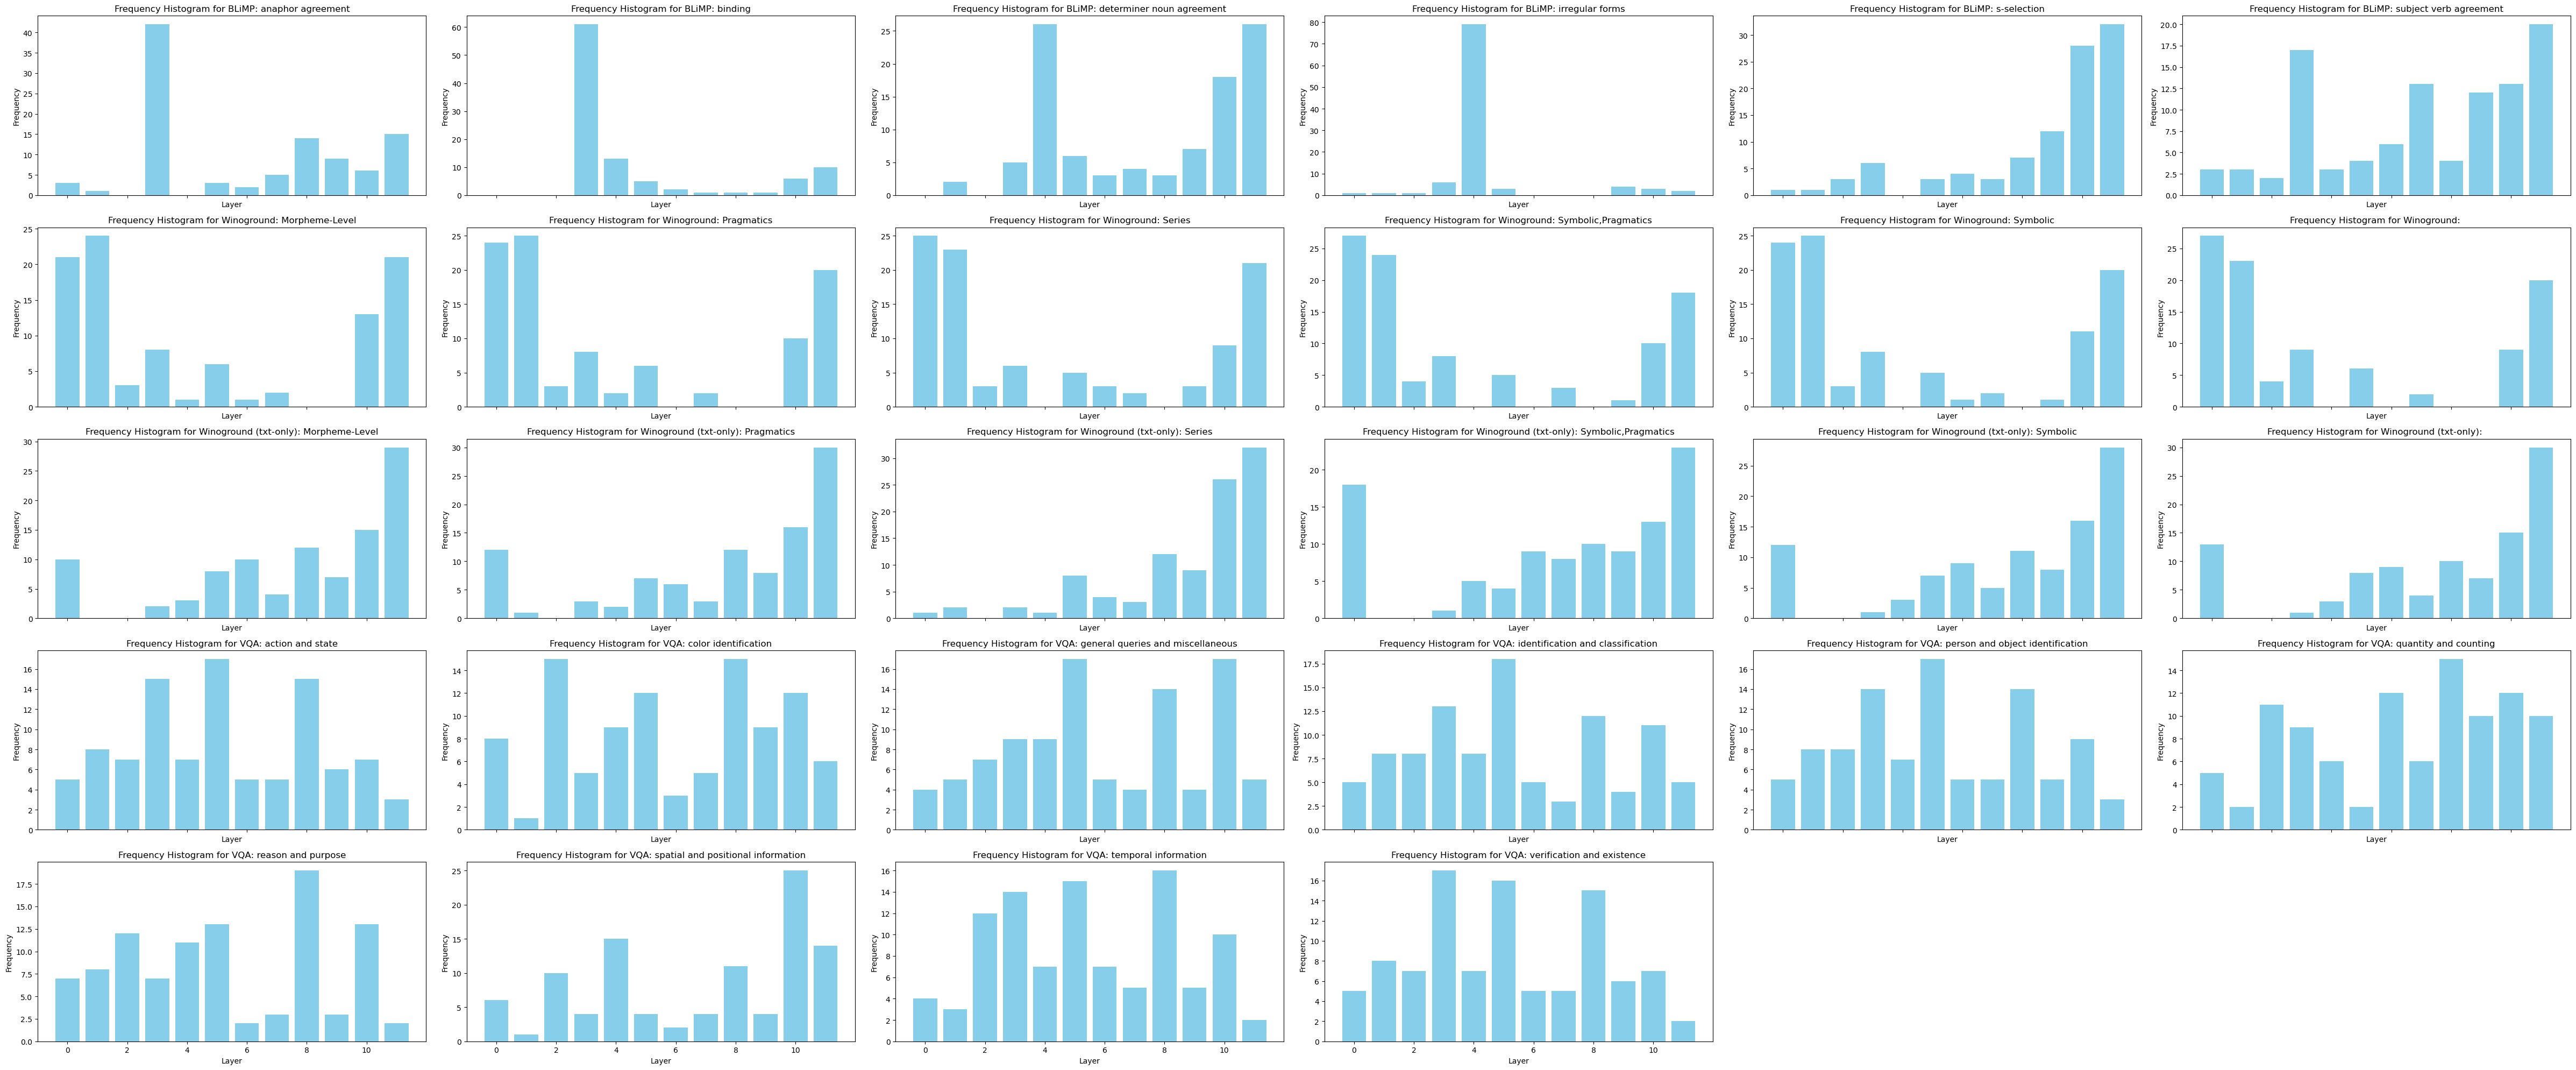

In [34]:
# Function to create subplots based on number of subtasks
def plot_frequency_histograms(subtasks_data):
    num_subtasks = len(subtasks_data)
    
    # Determine the number of rows and columns for a roughly balanced grid
    cols = math.ceil(math.sqrt(num_subtasks))
    rows = math.ceil(num_subtasks / cols)

    # Create subplots with the computed number of rows and columns
    fig, axes = plt.subplots(rows, cols, figsize=(8 * cols, 4 * rows), sharex=True)

    # Flatten axes array if it's a grid for easy indexing
    axes = axes.flatten()

    # Loop through each subtask and plot the frequency histogram
    for i, (subtask, layer_frequencies) in enumerate(subtasks_data.items()):
        axes[i].bar(layer_frequencies.keys(), layer_frequencies.values(), color='skyblue')
        axes[i].set_title(f"Frequency Histogram for {subtask}")
        axes[i].set_xlabel('Layer')
        axes[i].set_ylabel('Frequency')

    # Remove any empty subplots (in case of an uneven grid)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Call the function with the provided data
plot_frequency_histograms(layers_per_subtask)